In [1]:
filename = r'data/eitan/dsdna_d7+d17_50_50_1.spc'

In [2]:
run_id = 1

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tables

In [4]:
import phconvert as phc
phc.__version__

'0.5.3-7-gc062ec1'

In [5]:
import time

class Timer:
    def __init__(self, name):
        self.name = name
        
    def __enter__(self):
        self.start = time.clock()
        return self

    def __exit__(self, *args):
        self.end = time.clock()
        self.interval = self.end - self.start

# Author

In [6]:
author = 'Eitan Lerner'
author_affiliation = 'UCLA'
creator = 'Antonino Ingargiola'
creator_affiliation = 'UCLA'

# Sample

In [7]:
comment = 'A demostrative smFRET-nsALEX measurement.'
sample_name = '50-50 mixture of two FRET samples'
dye_names = 'ATTO550, ATTO647N'
buffer_name = 'TE50'

# Prepare data

## Read the data

In [8]:
with Timer('bh_read_speed_native') as t:
    timestamps, detectors, nanotimes = phc.bhreader.load_spc(filename)

In [9]:
read_speed_native_numpy = pd.DataFrame({'native_numpy': t.interval}, index=[0])
read_speed_native_numpy

,native_numpy
0,0.76299


In [10]:
timestamps.size

9716848

In [11]:
(timestamps[-1]-timestamps[0])*60e-9

2262.7105348199998

In [12]:
d, meta = phc.loader.nsalex_bh(filename,
                               donor = 4,
                               acceptor = 6,
                               laser_repetition_rate = 40e6,
                               tcspc_range = 60e-9,
                               timestamps_unit = 60e-9,
                               alex_period_donor = (1750, 3300),
                               alex_period_acceptor = (250, 1650),
                               excitation_wavelengths = (532e-9, 635e-9),
                               detection_wavelengths = (580e-9, 680e-9),
                               time_reversed = False,
                               allow_missing_set = False)

 - Loading 'data/eitan/dsdna_d7+d17_50_50_1.spc' ... 
 [DONE]

Ignoring arguments `timestamps_units` and `tcspc_range`.
These values were retrived from .SET file.


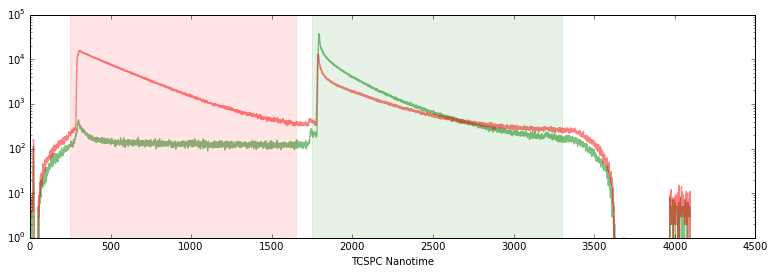

In [13]:
fig, ax = plt.subplots(figsize=(13, 4))
phc.plotter.alternation_hist(d, ax=ax)

In [14]:
d['provenance']

{'creation_time': '2014-03-25 15:58:14',
 'filename': 'data/eitan/dsdna_d7+d17_50_50_1.spc',
 'software': 'Becker & Hickl SPCM'}

In [15]:
detectors = d['photon_data']['detectors']
print('Detector numbers: ', np.unique(detectors))

('Detector numbers: ', array([0, 1, 4, 6], dtype=uint8))


In [16]:
pd.Series(detectors).value_counts()

6    6371466
4    3345380
1          1
0          1
dtype: int64

## Add author and sample info

In [17]:
d['comment'] = comment

d['sample'] = dict(
    sample_name=sample_name,
    dye_names=dye_names,
    buffer_name=buffer_name,
    num_dyes = len(dye_names.split(',')))

d['identity'] = dict(
    author=author,
    author_affiliation=author_affiliation,
    creator=creator,
    creator_affiliation=creator_affiliation)

# Validate the Photon-HDF5 structure

Before writing to disk, we assure the file structure follows the Photon-HDF5 format:

In [18]:
phc.hdf5.assert_valid_photon_hdf5(d)  # Throws an error if not valid!

# Save to Photon-HDF5

In [19]:
write_speed_ = {}
file_size_ = {}
for complib in ['zlib', 'blosc']:
    for complevel in range(0, 10):
        compression = {'complevel': complevel, 'complib': complib}
        fn = "%s_%s%d.hdf5" % (filename[:-4], complib, complevel)
        print (fn)
        with Timer(fn) as t:
            phc.hdf5.save_photon_hdf5(d, close=True, h5_fname=fn, compression=compression)
        write_speed_[(complib, complevel)] = t
        file_size_[(complib, complevel)] = os.path.getsize(fn)

data/eitan/dsdna_d7+d17_50_50_1_zlib0.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib0.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib1.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib1.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib2.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib2.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib3.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib3.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib4.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib4.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib5.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib5.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib6.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib6.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib7.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib7.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib8.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib8.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib9.hdf5
Saving: data/eitan/dsdna_d7+d17_50_50_1_zlib9.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc0.hdf5
Saving: data/eit

In [20]:
t_blosc = [write_speed_[key].interval for key in sorted(write_speed_.keys())if key[0] == 'blosc']
t_zlib = [write_speed_[key].interval for key in sorted(write_speed_.keys())if key[0] == 'zlib']

size_blosc = [file_size_[key] for key in sorted(file_size_.keys())if key[0] == 'blosc']
size_zlib = [file_size_[key] for key in sorted(file_size_.keys())if key[0] == 'zlib']

In [23]:
write_speed = pd.DataFrame({'zlib': t_zlib, 'blosc': t_blosc})
file_size = pd.DataFrame({'zlib': size_zlib, 'blosc': size_blosc})
file_size['native'] = os.path.getsize(filename)

In [38]:
file_size

,blosc,zlib,native
0,107227112,107227112,58301088
1,59066014,38073674,58301088
2,59044956,37829279,58301088
3,58850871,37645381,58301088
4,46276220,36710452,58301088
5,46276220,36399041,58301088
6,42517549,36271748,58301088
7,42406901,36199025,58301088
8,42913224,36156827,58301088
9,43456204,36142247,58301088


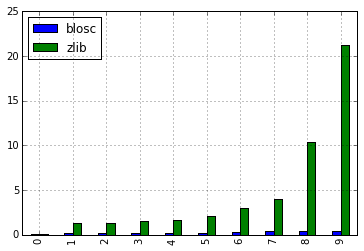

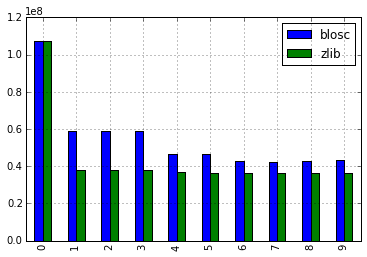

In [24]:
write_speed.plot(kind='bar')
file_size.plot(kind='bar')

(0, 5)

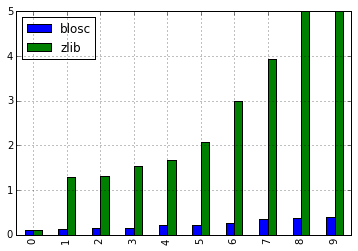

In [25]:
write_speed.plot(kind='bar')
plt.ylim(0, 5)

In [ ]:
write_speed.to_hdf('benchmark%d.h5' % run_id, key='bh_write_speed')

In [39]:
file_size.to_hdf('benchmark%d.h5' % run_id, key='bh_file_size')

# Read speed

In [27]:
read_speed_ = {}
cache = []
for complib in ['zlib', 'blosc']:
    for complevel in range(0, 10):
        fn = "%s_%s%d.hdf5" % (filename[:-4], complib, complevel)
        print (fn)
        assert os.path.exists(fn)
        with Timer(fn) as t:
            
            with tables.open_file(fn) as h5:
                a = h5.root.photon_data.timestamps.read()
                b = h5.root.photon_data.detectors.read()
                c = h5.root.photon_data.nanotimes.read()
                
        cache.append((a,b,c))        
        read_speed_[(complib, complevel)] = t
del cache

data/eitan/dsdna_d7+d17_50_50_1_zlib0.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib1.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib2.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib3.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib4.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib5.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib6.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib7.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib8.hdf5
data/eitan/dsdna_d7+d17_50_50_1_zlib9.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc0.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc1.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc2.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc3.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc4.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc5.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc6.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc7.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc8.hdf5
data/eitan/dsdna_d7+d17_50_50_1_blosc9.hdf5


In [28]:
t_blosc = [read_speed_[key].interval for key in sorted(read_speed_.keys())if key[0] == 'blosc']
t_zlib = [read_speed_[key].interval for key in sorted(read_speed_.keys())if key[0] == 'zlib']

In [29]:
read_speed = pd.DataFrame({'zlib': t_zlib, 'blosc': t_blosc})

In [30]:
read_speed = read_speed.join(read_speed_native_numpy)

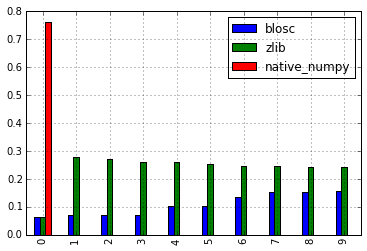

In [31]:
read_speed.plot(kind='bar')

In [32]:
read_speed

,blosc,zlib,native_numpy
0,0.061742,0.063829,0.76299
1,0.070063,0.279468,NaN
2,0.070565,0.269170,NaN
3,0.070368,0.258538,NaN
4,0.103374,0.260765,NaN
5,0.103392,0.251044,NaN
6,0.133330,0.246238,NaN
7,0.152176,0.245270,NaN
8,0.151008,0.243387,NaN
9,0.155041,0.243419,NaN


In [33]:
read_speed.to_hdf('benchmark%d.h5' % run_id, key='bh_read_speed')